In [13]:
import Pkg
Pkg.activate(pwd())

using HTTP
using Gumbo
using AbstractTrees
using Dates
using DataFrames

using VegaLite
using DataVoyager

using TextAnalysis
using JSON


In [2]:
function getURLBody(url::String)
    resp = HTTP.get(url)
    doc = parsehtml(String(resp.body));
    return doc.root[2];
end

getURLBody (generic function with 1 method)

In [131]:
# fetch the talk data
# WARNING: this may take a few minutes
url = "https://pretalx.com/juliacon2019/talk/";
body = getURLBody(url);

talks = Gumbo.children(body[2][2][1])

base_talk_url = "https://pretalx.com"

data = NamedTuple{(:index, :title, :url, :datetime, :duration, :location, :text), 
                    Tuple{Int, String, String, DateTime, Int, String, String}}[]
i = 1

for talk in talks
    # skip any non-talks
    typeof(talk) !== HTMLElement{:section} && continue
    
    # parse out the talk url
    a = talk[1][1]
    link = getattr(a, "href")
    
    # scrape the talk page for data
    talk_url = base_talk_url * link
    talk_body = getURLBody(talk_url)
    article = talk_body[2][2][1][1]
    
    # get the title, logistics, and text fields
    title = string(strip(article[1][1][1].text, ['\n', ' ', '\t']))
    d, t, l = split(strip(article[1][2][1].text, ['\n', ' ', '\t']), ", ")
    date = Date(d)
    start_time, end_time = Time.(split(t, "–"))
    datetime = DateTime(date, start_time)
    duration = Minute(end_time - start_time).value
    location = string(l)
    
    location == "Other" && continue # skip non-talks
    title == "Hackathon" && continue # skip the hackathon
    location[1:2] == "PH" && continue # skip workshops
    
    text = ""
    for elem in PreOrderDFS(article[2][1]) 
        # will fail on HTMLText, where text actually is
        try
            tag(elem) == :section && getattr(elem, "class") in ["resources", "answers"] && break
        catch
            p = elem.text
            # remove html tags used for styling
            text *= replace(p, r"<.*>" => " ") * " "   
        end
    end
    
    # save to array
    push!(data, NamedTuple{
                    (:index, :title, :url, :datetime, :duration, :location, :text), 
                    Tuple{Int, String, String, DateTime, Int, String, String}}(
                        (i, title, link, datetime, duration, location, text)
                    )
        )
        
    i += 1
end

In [105]:
# run data voyager
data |> Voyager()

Voyager(Electron.Window(Application(Base.PipeEndpoint(RawFD(0x0000003c) paused, 0 bytes waiting), Process(`/Users/mmcgrat3/.julia/packages/Electron/wL84D/src/../deps/electron/Julia.app/Contents/MacOS/Julia /Users/mmcgrat3/.julia/packages/Electron/wL84D/src/main.js /var/folders/9p/dsyzpxf570dd8nl9v4gz1mw80000gp/T/juliaelectron-9028-1 /var/folders/9p/dsyzpxf570dd8nl9v4gz1mw80000gp/T/juliaelectron-sysnotify-9028-1 lDZjV+b3GqnsEHXd/VeZBZDbDzFhj1f2OL7HnIbA2oLpgFw+WEZ7vzPc8w8DOI3leQu0BPnMjtVpMIVn1oK+f5xUvrV0uQZGngh6nM92jIkyFB3AqSMTBIdloaxqD22xOT6DOmj5klb4hCNMc3tQ/41F3T2Rmw1leaNNKnIoPgQ=`, ProcessRunning), [2 windows]), 2, true, Channel{Any}(sz_max:128,sz_curr:0)))

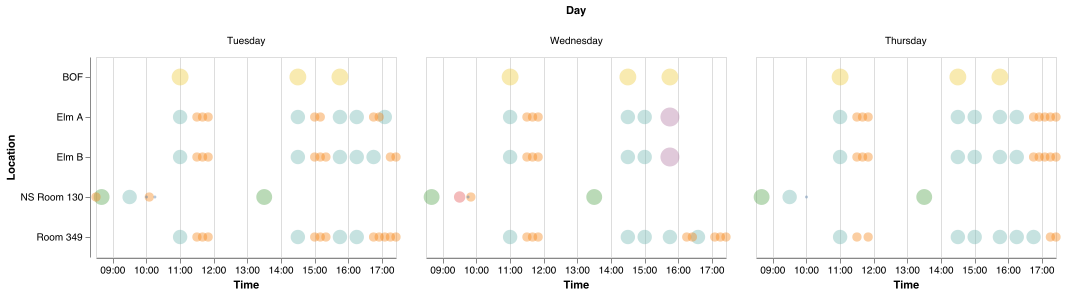

In [142]:
spec = vl"""{
  "height": 200,
  "width": 300,
  "data": {
    "vaues": []
  },
  "selection": {
    "paintbrush": {
      "type": "multi",
      "on": "mouseover", "empty": "none"
    }
  },
  "mark": {
      "type": "point", 
      "filled": true,
      "opacity": 1.0
  },
  "encoding": {
    "column": {
      "field": "datetime",
      "title": "Day",
      "type": "ordinal",
      "timeUnit": "day"
    },
    "x": {
      "field": "datetime",
      "title": "Time",
      "type": "temporal",
      "timeUnit": "hoursminutes",
      "axis": {
        "orient": "bottom"
      }
    },
    "y": {
      "field": "location",
      "title": "Location",
      "type": "nominal"
    },
    "size": {
      "field": "duration",
      "type": "quantitative",
      "scale": {
        "type": "log"
      },
      "legend": null
    },
    "color": {
      "field": "duration",
      "type": "nominal",
      "legend": null
    },
    "fillOpacity": {
      "condition": {
        "selection": "paintbrush", "value": 1.0
      },
      "value": 0.4
    },
    "tooltip": [
      {"field": "title", "type": "nominal"},
      {"field": "location", "title": "Room", "type": "nominal"},
      {"field": "datetime", "title": "Date & Time", "type": "temporal", "timeUnit": "yearmonthdatehoursminutes"}
    ]
  },
  "config": {
    "overlay": {
      "line": true
    },
    "scale": {
      "useUnaggregatedDomain": true
    }
  }
}"""(data)

In [251]:
# Let's do some NLP

# create the corpus
sds = map(x -> StringDocument(x.text), data)
corpus = Corpus(sds)

# clean up the data
remove_case!(corpus)
prepare!(corpus, strip_articles| strip_non_letters| strip_stopwords| strip_pronouns)
remove_words!(corpus, ["julia", "jl", "talk", "using"]) # too common :(

# set up the lexicon
lexicon(corpus)
update_lexicon!(corpus)

# light stemming - simple 's' plurals
pairs = Pair{String, String}[]
for (k, v) in lexicon(corpus)
    if k[end] == 's' && haskey(lexicon(corpus), k[1:end-1])
        push!(pairs, k => k[1:end-1])
    end
end

# replace plurals and update the lexicon
for doc in corpus
    for pair in pairs
        doc.text = replace(doc.text, pair)
    end
end
update_lexicon!(corpus)

# set up inverse index
inverse_index(corpus)
update_inverse_index!(corpus)

In [252]:
# bi-grams

bg = NGramDocument[]

for d in corpus
    push!(bg, NGramDocument(ngrams(d, 2), 1, d.metadata))
end

bg_corpus = Corpus(bg)

# set up inverse index
inverse_index(bg_corpus)
update_inverse_index!(bg_corpus)

# set up the lexicon
lexicon(bg_corpus)
update_lexicon!(bg_corpus)

In [253]:
# tri-grams

tg = NGramDocument[]

for d in corpus
    push!(tg, NGramDocument(ngrams(d, 3), 1, d.metadata))
end

tg_corpus = Corpus(tg)

# set up inverse index
inverse_index(tg_corpus)
update_inverse_index!(tg_corpus)

# set up the lexicon
lexicon(tg_corpus)
update_lexicon!(tg_corpus)

In [254]:
function subgram_count(term, np1grams)
    count = 0
    for (k, v) in np1grams
        if occursin(term, k)
            count += v
        end
    end
    
    return count
end

subgram_count (generic function with 1 method)

In [255]:
function remove_ngrams(ngrams, np1grams, cut_off)
    new_ngrams = Dict{String, Int}()
    for (k, v) in ngrams
        new_count = v - subgram_count(k, np1grams)
        if new_count > cut_off
            new_ngrams[k] = new_count
        end
    end
    
    return merge(new_ngrams, np1grams)
end

remove_ngrams (generic function with 2 methods)

In [256]:
function remove_ngrams(ngrams, cut_off)
    new_ngrams = Dict{String, Int}()
    for (k, v) in ngrams
        if v > cut_off
            new_ngrams[k] = v
        end
    end
    
    return new_ngrams
end

remove_ngrams (generic function with 2 methods)

In [257]:
# combine ngrams and fine most commone words and phrases
tg_cut_off = 2
bg_cut_off = 4
ug_cut_off = 15

new_tg = remove_ngrams(lexicon(tg_corpus), tg_cut_off)
new_bg = remove_ngrams(lexicon(bg_corpus), new_tg, bg_cut_off)
new_ug = remove_ngrams(lexicon(corpus), new_bg, ug_cut_off)

# freq_words = filter(x -> x.second >= cut_off, lexicon(crp))

word_data = NamedTuple{(:text, :count, :talks), Tuple{String, Int, Array}}[]
for (word, count) in new_ug
    inds = []
    word_len = length(split(word))
    if word_len == 3
        inds = inverse_index(tg_corpus)[word]
    elseif word_len == 2
        inds = inverse_index(bg_corpus)[word]
    else
        inds = inverse_index(corpus)[word]
    end
    push!(word_data, NamedTuple{(:text, :count, :talks), Tuple{String, Int, Array}}((word, count * word_len, inds)))
end

word_data_json = JSON.json(word_data);

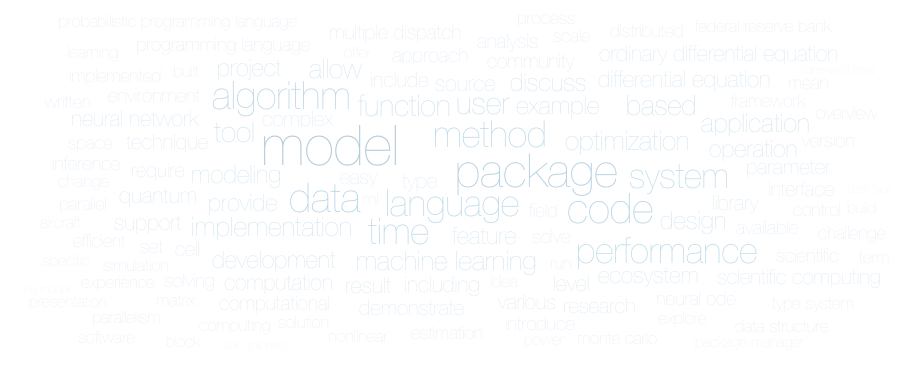

In [258]:
word_cloud_spec = """{
  "width": 900,
  "height": 350,
  "padding": 10,
  "signals": [
    {"name": "hoverID", "value": 0}
  ],

  "data": [
    {
      "name": "table",
      "values": $(word_data_json)
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "log",
      "domain": {"data": "table", "field": "count"},
      "range": {"scheme": "purpleblue"}
    }
  ],

  "marks": [
    {
      "type": "text",
      "from": {"data": "table"},
      "encode": {
        "enter": {
          "text": {"field": "text"},
          "align": {"value": "center"},
          "baseline": {"value": "alphabetic"},
          "fill": {"scale": "color", "field": "count"}
        },
        "update": {
          "fillOpacity": [
            {"test": "indexof(datum.talks, hoverID) > 0", "value": 1.0},
            {"value": 0.3}
          ]
        },
        "hover": {
          "fillOpacity": {"value": 1.0}
        }
      },
      "transform": [
        {
          "type": "wordcloud",
          "size": [{"signal": "width"}, {"signal": "height"}],
          "text": {"field": "text"},
          "font": "Helvetica Neue, Arial",
          "fontSize": {"field": "datum.count"},
          "fontSizeRange": [12, 56],
          "padding": 2
        }
      ]
    }
  ]
}"""

VegaLite.VGSpec(JSON.parse(word_cloud_spec))


In [262]:
new_ug

Dict{String,Int64} with 157 entries:
  "computing"                     => 18
  "scientific"                    => 20
  "neural ode"                    => 10
  "complex"                       => 25
  "build"                         => 16
  "parallel"                      => 19
  "recommender system"            => 5
  "multiple dispatch"             => 11
  "data"                          => 86
  "overview"                      => 19
  "stochastic dual dynamic"       => 4
  "environment"                   => 20
  "user"                          => 49
  "package environment"           => 6
  "factor graph based"            => 3
  "solve"                         => 21
  "operation"                     => 32
  "include"                       => 24
  "mean"                          => 19
  "tool"                          => 43
  "programming language"          => 10
  "federal reserve bank"          => 6
  "differential equation machine" => 3
  "monte carlo iteration"         => 4
  "based" 

In [261]:
lexicon(corpus)["model"]

158

In [236]:
new_ug["machine learning"]

25

In [237]:
new_bg["machine learning"]

25

In [238]:
subgram_count("machine", new_bg)

2